In [1]:
!pip install pandas
%pip install tensorflow
%pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("train.csv")

diagnosis_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}

diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df["binary"] = df["diagnosis"].map(diagnosis_binary.get)
df["type"] = df["diagnosis"].map(diagnosis_classes.get)

<Axes: ylabel='type'>

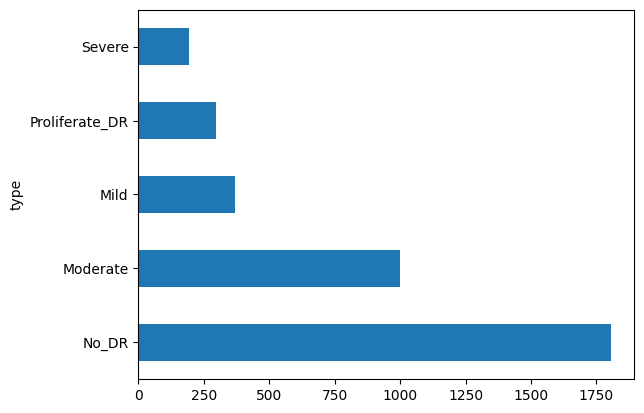

In [4]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary'>

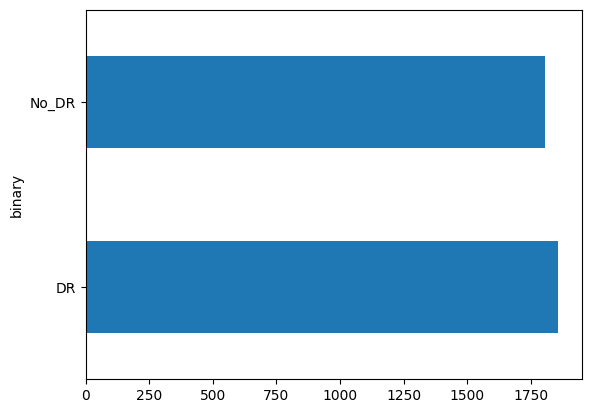

In [5]:
df['binary'].value_counts().plot(kind='barh')

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
%pip install imutils
from imutils import paths
from sklearn.utils import shuffle


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
data = []
labels = []
width,height=224,224

imagePaths = list(paths.list_images('gaussian_filtered_images'))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

(3662, 224, 224, 3)
(3662, 5)


In [8]:
data = data / 255.0

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (2929, 224, 224, 3)
Test images: (733, 224, 224, 3)
Train label: (2929, 5)
Test label: (733, 5)


In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_val.shape)
print("Train label:",y_train.shape)
print("Test label:",y_val.shape)

Train images: (2343, 224, 224, 3)
Test images: (586, 224, 224, 3)
Train label: (2343, 5)
Test label: (586, 5)


In [11]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras import layers

In [12]:
Vgg16 = VGG16(include_top=False, input_shape= (224,224,3)) 

Vgg16.trainable=False

In [13]:
model = Sequential()
model.add(Vgg16)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(32 , activation="relu"))
#model.add(Dropout(0.25))
model.add(Dense(5 , activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,322,629 (62.27 MB)

 Trainable params: 1,607,941 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(x_train , y_train , epochs=10 , batch_size=64,
                    validation_data=(x_val,y_val), verbose=1 , callbacks=callbacks)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 516s 14s/step - binary_accuracy: 0.8242 - loss: 0.4361 - val_binary_accuracy: 0.8932 - val_loss: 0.2519
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 602s 16s/step - binary_accuracy: 0.8907 - loss: 0.2860 - val_binary_accuracy: 0.8986 - val_loss: 0.2461
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 727s 20s/step - binary_accuracy: 0.8978 - loss: 0.2676 - val_binary_accuracy: 0.9027 - val_loss: 0.2306
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 546s 15s/step - binary_accuracy: 0.8976 - loss: 0.2562 - val_binary_accuracy: 0.9044 - val_loss: 0.2337
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 456s 12s/step - binary_accuracy: 0.9007 - loss: 0.2436 - val_binary_accuracy: 0.9072 - val_loss: 0.2295
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 480s 13s/step - binary_accuracy: 0.9012 - loss: 0.2409 - val_binary_accuracy: 0.9048 - val_loss: 0.2298
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1265s 35s/step - binary_accuracy: 0.9000 - loss: 0.2482 - val_binary_accuracy: 0.9014 - val_loss: 0.2326
Epoch

In [16]:
import os.path
if os.path.isfile('models/new_trained_model.h5') is False:
    model.save('models/new_trained_model.h5')

In [17]:
from tensorflow.keras.models import load_model
new_model = load_model('models/new_trained_model.h5')

In [18]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,322,631 (62.27 MB)

 Trainable params: 1,607,941 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

In [19]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.plot(epochs, loss, label = "training_loss")
  plt.xlabel("epochs")
  plt.title("loss")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

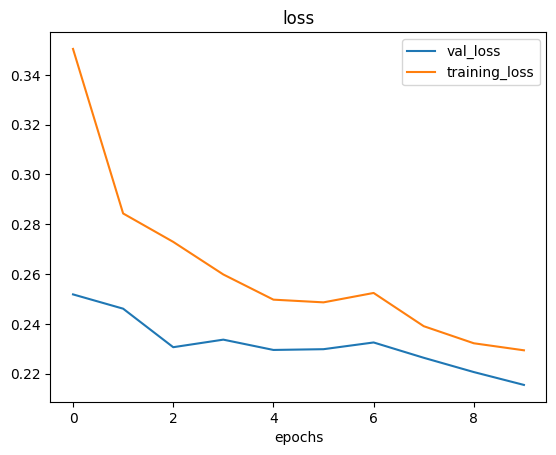

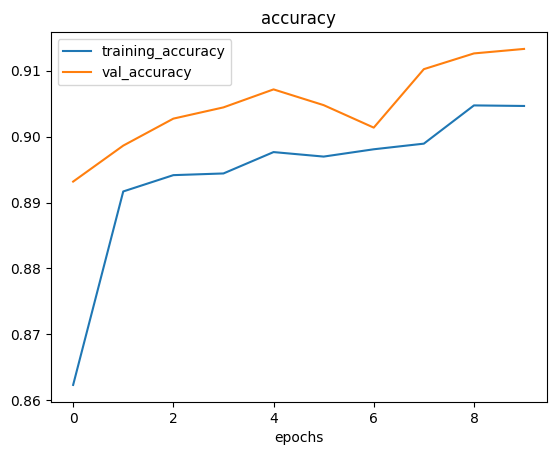

In [20]:
plot_curves(history)

In [21]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step


[0 0 1 0 0]
Prediction: NO_DR


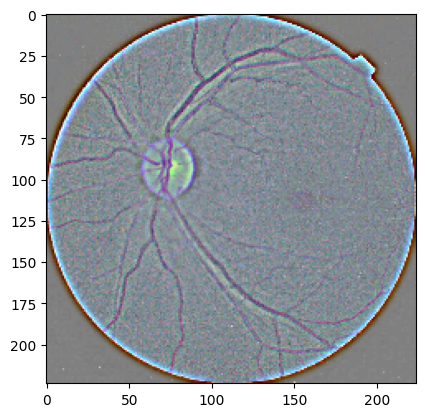

In [22]:
index =5
predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 

img = x_test[index]
RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
RGBImg= cv2.resize(RGBImg,(224,224))

plt.imshow(RGBImg)
print(y_test[index]) # true
print(f"Prediction: {predictions[pred[index]]}")# predicted

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 
def predict_new(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=new_model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Predicted: Mild


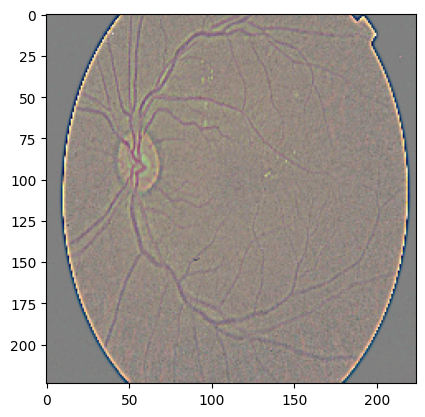

In [24]:
predict_new("gaussian_filtered_images/Mild/01b3aed3ed4c.png")